# ECE176 Final Project

In [2]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [2]:
import torch
print(torch.__version__)          # Should show a version with CUDA (not CPU)
print(torch.cuda.is_available())  # Should return True
print(torch.version.cuda)         # Should match your CUDA version

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(device)
    gpu_capability = torch.cuda.get_device_capability(device)
    total_memory = torch.cuda.get_device_properties(device).total_memory / 1e9  # Convert to GB

    print(f"GPU Name: {gpu_name}")
    print(f"Compute Capability: {gpu_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    print("CUDA device not available.")


2.6.0+cu118
True
11.8
GPU Name: NVIDIA GeForce RTX 3080 Laptop GPU
Compute Capability: (8, 6)
Total Memory: 17.18 GB


In [ ]:
import mido
from mido import MidiFile, MidiTrack, Message, second2tick

def decode_token_sequence(token_sequence, output_midi_path, ticks_per_beat=480, tempo=500000):
    """
    Decodes a list of tokens into a MIDI file.
    
    Parameters:
      token_sequence (list): List of tokens (strings) e.g. "NOTE_ON_60", "VELOCITY_25", "TIME_SHIFT_10ms", etc.
      output_midi_path (str): Filename for the output MIDI file.
      ticks_per_beat (int): MIDI ticks per beat.
      tempo (int): Tempo in microseconds per beat.
    """
    mid = MidiFile(ticks_per_beat=ticks_per_beat)
    track = MidiTrack()
    mid.tracks.append(track)
    
    # This variable accumulates delta time (in ticks) until the next event.
    accumulated_time_ticks = 0
    i = 0
    while i < len(token_sequence):
        token = token_sequence[i]
        if token.startswith("TIME_SHIFT_"):
            # Extract the millisecond value from token, e.g. "TIME_SHIFT_10ms" -> 10
            ms_value = int(token[len("TIME_SHIFT_"):-2])
            seconds = ms_value / 1000.0
            # Convert seconds to ticks
            ticks = second2tick(seconds, ticks_per_beat, tempo)
            accumulated_time_ticks += int(round(ticks))
            i += 1

        elif token.startswith("NOTE_ON_"):
            # Get the MIDI note (pitch)
            note = int(token[len("NOTE_ON_"):])
            i += 1
            # Expect the following token to be a VELOCITY token
            if i >= len(token_sequence) or not token_sequence[i].startswith("VELOCITY_"):
                raise ValueError("Expected a VELOCITY token following NOTE_ON.")
            velocity_bin = int(token_sequence[i][len("VELOCITY_"):])
            # In the encoding, the velocity bin is in [1,32]; to approximate the original velocity in [0,127]
            velocity = int(round((velocity_bin / 32) * 127))
            # Create the note_on message with the accumulated delta time
            msg = Message("note_on", note=note, velocity=velocity, time=accumulated_time_ticks)
            track.append(msg)
            accumulated_time_ticks = 0  # Reset the delta time
            i += 1

        elif token.startswith("NOTE_OFF_"):
            # Get the MIDI note to turn off
            note = int(token[len("NOTE_OFF_"):])
            msg = Message("note_off", note=note, velocity=0, time=accumulated_time_ticks)
            track.append(msg)
            accumulated_time_ticks = 0  # Reset the delta time
            i += 1

        else:
            raise ValueError(f"Unrecognized token: {token}")

    # Save the MIDI file
    mid.save(output_midi_path)
    print(f"MIDI file saved as {output_midi_path}")

if __name__ == "__main__":
    # Example token sequence (it can be loaded from a file or another source)
    token_sequence_str = (
        "NOTE_ON_60 VELOCITY_25 TIME_SHIFT_10ms NOTE_OFF_60 NOTE_ON_55 VELOCITY_25 TIME_SHIFT_10ms "
        "NOTE_ON_44 VELOCITY_25 NOTE_ON_60 VELOCITY_25 NOTE_ON_55 VELOCITY_25 NOTE_ON_55 VELOCITY_24 "
        "TIME_SHIFT_10ms NOTE_ON_35 VELOCITY_30 NOTE_ON_35 VELOCITY_25 NOTE_ON_60 VELOCITY_30 "
        "TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_ON_63 VELOCITY_31 TIME_SHIFT_10ms NOTE_OFF_35 "
        "NOTE_ON_63 VELOCITY_25 TIME_SHIFT_20ms TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_OFF_35 "
        "TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_ON_35 VELOCITY_32 NOTE_OFF_35 TIME_SHIFT_150ms "
        "NOTE_OFF_44 NOTE_ON_35 VELOCITY_25 NOTE_OFF_35 NOTE_ON_44 VELOCITY_28 NOTE_ON_68 VELOCITY_27 "
        "TIME_SHIFT_10ms NOTE_OFF_66 TIME_SHIFT_10ms TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_OFF_35 "
        "NOTE_OFF_35 TIME_SHIFT_10ms TIME_SHIFT_10ms TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_OFF_60 "
        "VELOCITY_28 NOTE_ON_44 VELOCITY_25 TIME_SHIFT_10ms NOTE_ON_35 VELOCITY_26 TIME_SHIFT_30ms "
        "TIME_SHIFT_10ms "
        "NOTE_ON_35 VELOCITY_25 TIME_SHIFT_10ms NOTE_OFF_35 TIME_SHIFT_20ms TIME_SHIFT_10ms "
        "NOTE_ON_35 VELOCITY_24 NOTE_ON_35 VELOCITY_32 TIME_SHIFT_10ms NOTE_OFF_44 TIME_SHIFT_10ms "
        "NOTE_OFF_35 TIME_SHIFT_40ms TIME_SHIFT_10ms NOTE_OFF_60 TIME_SHIFT_110ms NOTE_OFF_35 "
        "TIME_SHIFT_20ms TIME_SHIFT_10ms TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_OFF_35 "
        "NOTE_ON_42 VELOCITY_26 NOTE_ON_40 VELOCITY_29 TIME_SHIFT_10ms TIME_SHIFT_10ms TIME_SHIFT_10ms "
        "NOTE_OFF_44 TIME_SHIFT_20ms TIME_SHIFT_10ms NOTE_OFF_63 TIME_SHIFT_20ms TIME_SHIFT_10ms "
        "TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_OFF_40 TIME_SHIFT_10ms NOTE_ON_44 VELOCITY_11 "
        "TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_OFF_35 TIME_SHIFT_20ms TIME_SHIFT_10ms NOTE_OFF_63 "
        "NOTE_OFF_61 TIME_SHIFT_20ms TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_OFF_34 TIME_SHIFT_10ms "
        "NOTE_OFF_35 TIME_SHIFT_10ms TIME_SHIFT_10ms NOTE_ON_35 VELOCITY_25 TIME_SHIFT_10ms"
    )
    tokens = token_sequence_str.split()
    decode_token_sequence(tokens, "decoded_output.mid")


Loading original MIDI file: 016c515bc5a8139fbd1bb599bc7d9c0c.mid
Ticks per beat: 120
Extracted global tempo: 458015 µs/beat ( 131.0 BPM )

Extracting instrument mapping and note channel order...
Instrument mapping extracted: {9: 0, 1: 33, 2: 29, 3: 27, 4: 30, 5: 29, 6: 80, 7: 29, 8: 31, 0: 27, 11: 56}
Total note events (channel order) extracted: 9368

Reconstructing MIDI from token sequence with instrument and tempo assignments...
Inserted global set_tempo message (tempo = 458015 µs/beat).
Assigned instrument (program 27) to channel 0.
Assigned instrument (program 33) to channel 1.
Assigned instrument (program 29) to channel 2.
Assigned instrument (program 27) to channel 3.
Assigned instrument (program 30) to channel 4.
Assigned instrument (program 29) to channel 5.
Assigned instrument (program 80) to channel 6.
Assigned instrument (program 29) to channel 7.
Assigned instrument (program 31) to channel 8.
Assigned instrument (program 0) to channel 9.
Assigned instrument (program 56) to 

Reconstructing tokens: 100%|█████████▉| 24759/24760 [00:00<00:00, 419769.48token/s]

Encountered TOKEN_END. Finishing reconstruction.

MIDI reconstruction complete. Total messages in track: 9380
Reconstructed MIDI file with tempo and instrument assignments saved as: reconstructed_with_tempo.mid


In [ ]:
import mido
from mido import MidiFile, MidiTrack, Message, second2tick

def decode_token_sequence(token_sequence, output_midi_path, ticks_per_beat=480, tempo=500000):
    """
    Decodes a list of tokens into a MIDI file.
    
    Parameters:
      token_sequence (list): List of tokens (strings) e.g. "NOTE_ON_60", "VELOCITY_25", "TIME_SHIFT_10ms", etc.
      output_midi_path (str): Filename for the output MIDI file.
      ticks_per_beat (int): MIDI ticks per beat.
      tempo (int): Tempo in microseconds per beat.
    """
    mid = MidiFile(ticks_per_beat=ticks_per_beat)
    track = MidiTrack()
    mid.tracks.append(track)
    
    # This variable accumulates delta time (in ticks) until the next event.
    accumulated_time_ticks = 0
    i = 0
    while i < len(token_sequence):
        token = token_sequence[i]

        if token.startswith("TIME_SHIFT_"):
            # Extract the millisecond value from token, e.g. "TIME_SHIFT_10ms" -> 10
            try:
                ms_value = int(token[len("TIME_SHIFT_"):-2])
            except ValueError:
                print(f"Warning: Could not parse time shift token: {token}. Skipping.")
                i += 1
                continue
            seconds = ms_value / 1000.0
            # Convert seconds to ticks
            ticks = second2tick(seconds, ticks_per_beat, tempo)
            accumulated_time_ticks += int(round(ticks))
            i += 1

        elif token.startswith("NOTE_ON_"):
            try:
                note = int(token[len("NOTE_ON_"):])
            except ValueError:
                print(f"Warning: Could not parse NOTE_ON token: {token}. Skipping.")
                i += 1
                continue

            # Check if the next token is a VELOCITY token
            if i + 1 < len(token_sequence) and token_sequence[i+1].startswith("VELOCITY_"):
                velocity_token = token_sequence[i+1]
                try:
                    velocity_bin = int(velocity_token[len("VELOCITY_"):])
                except ValueError:
                    print(f"Warning: Could not parse velocity token: {velocity_token}. Using default velocity 64.")
                    velocity = 64
                else:
                    # Convert velocity bin (1-32) to approximate MIDI velocity (0-127)
                    velocity = int(round((velocity_bin / 32) * 127))
                msg = Message("note_on", note=note, velocity=velocity, time=accumulated_time_ticks)
                track.append(msg)
                accumulated_time_ticks = 0  # Reset delta time after event
                i += 2  # Skip the velocity token as well
            else:
                # If no velocity token follows, optionally use a default velocity
                print(f"Warning: Missing VELOCITY token after {token}. Using default velocity 64.")
                msg = Message("note_on", note=note, velocity=64, time=accumulated_time_ticks)
                track.append(msg)
                accumulated_time_ticks = 0
                i += 1

        elif token.startswith("NOTE_OFF_"):
            try:
                note = int(token[len("NOTE_OFF_"):])
            except ValueError:
                print(f"Warning: Could not parse NOTE_OFF token: {token}. Skipping.")
                i += 1
                continue
            msg = Message("note_off", note=note, velocity=0, time=accumulated_time_ticks)
            track.append(msg)
            accumulated_time_ticks = 0
            i += 1

        elif token.startswith("VELOCITY_"):
            # This token is unexpected (not following a NOTE_ON), so we skip it.
            print(f"Warning: Unexpected token {token} encountered; skipping.")
            i += 1

        else:
            print(f"Warning: Unrecognized token: {token}. Skipping.")
            i += 1

    mid.save(output_midi_path)
    print(f"MIDI file saved as {output_midi_path}")

tokens = token_sequence_str.split()
decode_token_sequence(tokens, "decoded_output_scale.mid")


MIDI file saved as decoded_output_scale.mid


In [30]:
import os

# Directories for the splits
train_dir = "datasets/raw_midi/lmd_clean_1track/train"
val_dir = "datasets/raw_midi/lmd_clean_1track/val"
test_dir = "datasets/raw_midi/lmd_clean_1track/test"

# Get file lists for each split
train_files = os.listdir(train_dir)
val_files = os.listdir(val_dir)
test_files = os.listdir(test_dir)

# Convert to sets for uniqueness testing
train_set = set(train_files)
val_set = set(val_files)
test_set = set(test_files)

# Print the number of files in each split
print(f"Train set contains: {len(train_files)} files")
print(f"Validation set contains: {len(val_files)} files")
print(f"Test set contains: {len(test_files)} files")

# Check for uniqueness within each split
assert len(train_files) == len(train_set), "There are duplicate files in the train split!"
assert len(val_files) == len(val_set), "There are duplicate files in the validation split!"
assert len(test_files) == len(test_set), "There are duplicate files in the test split!"

# Check for uniqueness across splits (no file should appear in more than one split)
intersection_train_val = train_set.intersection(val_set)
intersection_train_test = train_set.intersection(test_set)
intersection_val_test = val_set.intersection(test_set)

print("\nIntersections:")
print(f"Train ∩ Validation: {intersection_train_val}")
print(f"Train ∩ Test: {intersection_train_test}")
print(f"Validation ∩ Test: {intersection_val_test}")

assert not intersection_train_val, "Some files are present in both train and validation splits!"
assert not intersection_train_test, "Some files are present in both train and test splits!"
assert not intersection_val_test, "Some files are present in both validation and test splits!"

print("\n✅ All splits are correct and all files are unique!")


Train set contains: 7979 files
Validation set contains: 996 files
Test set contains: 993 files

Intersections:
Train ∩ Validation: set()
Train ∩ Test: set()
Validation ∩ Test: set()

✅ All splits are correct and all files are unique!


In [ ]:
import os
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
TRAIN_DATA_PATH = "datasets/tokenized/val"
VOCAB_PATH = "datasets/vocab/basic_vocab.json"

# Load vocabulary
with open(VOCAB_PATH, "r") as f:
    vocab = json.load(f)

# Reverse vocab (ID -> Token)
id_to_token = {v: k for k, v in vocab.items()}

# Load tokenized sequences
def load_all_sequences(data_path, max_files=1000):
    """Loads all tokenized sequences from the specified dataset path."""
    sequences = []
    files = sorted(os.listdir(data_path))[:max_files]  # Limit for performance
    for file in files:
        if file.endswith(".pkl"):
            with open(os.path.join(data_path, file), "rb") as f:
                seq = pickle.load(f)
                if len(seq) == 0:
                    print(file)
                sequences.append(seq)
    return sequences

train_sequences = load_all_sequences(TRAIN_DATA_PATH)
print(f"Loaded {len(train_sequences)} tokenized sequences from {TRAIN_DATA_PATH}")


Loaded 996 tokenized sequences from datasets/tokenized/val


In [38]:
def ids_to_tokens(vocab, id_sequence):
    # Reverse the vocab (ID -> Token)
    id_to_token = {v: k for k, v in vocab.items()}

    # Convert token IDs back to tokens
    token_sequence = [id_to_token.get(token_id, "<UNK>") for token_id in id_sequence]

    return token_sequence




id_sequence = train_sequences[2]  # Example sequence of token IDs
tokens = ids_to_tokens(vocab, id_sequence)

print("Decoded Tokens:", tokens)


Decoded Tokens: ['TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_30ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_160ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_1

[259, 256, 259, 256, 263, 256, 263, 256, 263, 256, 271, 256, 256, 256, 256, 256, 265, 256, 259, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 257, 256, 256, 256, 256, 256, 256, 256, 259, 256, 256, 256, 256, 256, 256, 256, 256, 259, 256, 257, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 258, 256, 256, 256, 256, 256, 258, 256, 256, 256, 256, 256, 256, 256, 256, 256, 258, 256, 260, 256, 256, 257, 256, 267, 256, 261, 256, 259, 256, 256, 256, 256, 268, 256, 273, 256, 316, 256, 75, 381, 75, 385, 303, 256, 203, 203, 256, 73, 378, 73, 384, 278, 256, 201, 201, 256, 71, 374, 71, 378, 278, 256, 199, 199, 256, 68, 378, 68, 382, 277, 256, 196, 196, 256, 256, 66, 371, 66, 376, 275, 194, 194, 258, 256, 47, 375, 54, 375, 59, 375, 63, 375, 256, 47, 375, 54, 375, 256, 35, 380, 59, 376, 59, 382, 35, 384, 49, 375, 256, 59, 376, 256, 163, 177, 256, 63, 379, 275, 256, 187, 256, 175, 182, 256, 256, 59, 371, 51, 371, 256, 47, 368, 54, 369, 179, 275, 256, 175, 1

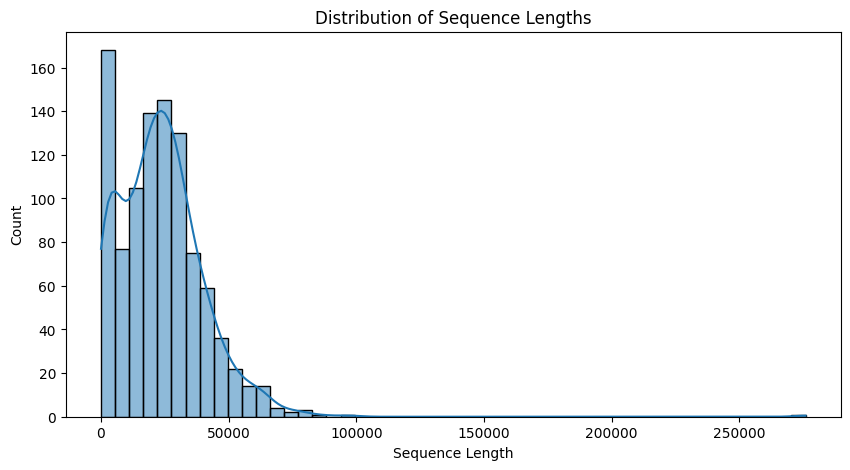

In [ ]:
seq_lengths = []
num_zero_len = 0
for seq in train_sequences:
    seq_lengths.append(len(seq))
    if len(seq) == 0:
        num_zero_len += 1

# Statistics
print(f"Min Length: {np.min(seq_lengths)}")
print(f"Max Length: {np.max(seq_lengths)}")
print(f"Mean Length: {np.mean(seq_lengths):.2f}")
print(f"Median Length: {np.median(seq_lengths)}")
print(f"Number of zero lenght sequences: {num_zero_len}")

# Histogram of sequence lengths
plt.figure(figsize=(10, 5))
sns.histplot(seq_lengths, bins=50, kde=True)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths")
plt.show()


Top 20 Most Frequent Tokens:
TIME_SHIFT_10ms: 6386218
TIME_SHIFT_20ms: 498862
VELOCITY_25: 414607
NOTE_OFF_42: 403143
NOTE_ON_42: 402721
TIME_SHIFT_30ms: 380510
VELOCITY_32: 347323
VELOCITY_20: 304136
VELOCITY_23: 294938
VELOCITY_24: 291773
VELOCITY_21: 264622
VELOCITY_22: 250361
VELOCITY_26: 238079
TIME_SHIFT_40ms: 230773
TIME_SHIFT_50ms: 223757
VELOCITY_28: 223494
VELOCITY_19: 218411
VELOCITY_16: 213529
VELOCITY_18: 207475
NOTE_OFF_62: 202414


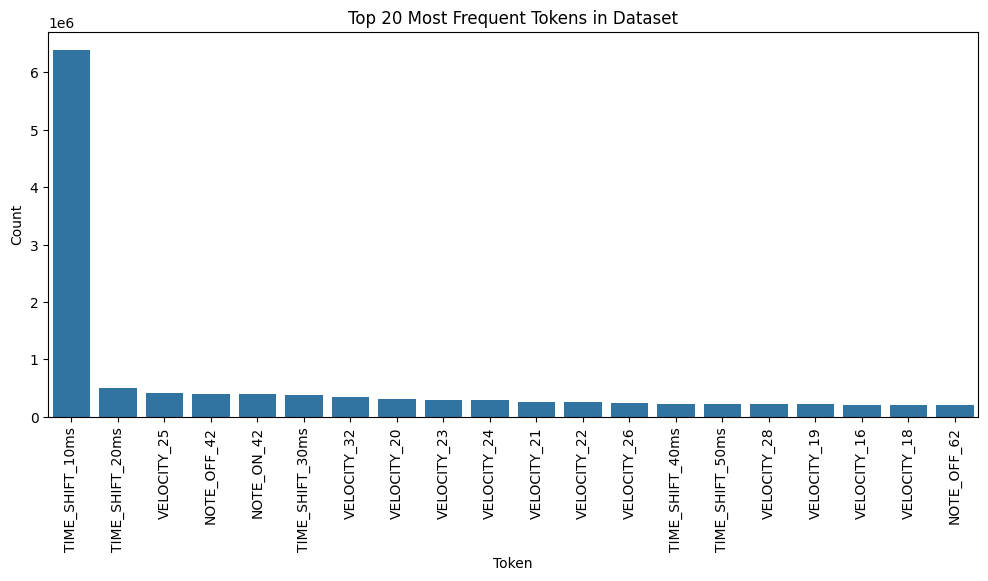

In [ ]:
from collections import Counter

# Flatten sequences into a single list of token IDs
all_tokens = [token for seq in train_sequences for token in seq]

# Count token occurrences
token_counts = Counter(all_tokens)

# Convert to token names
token_names = {id_to_token[k]: v for k, v in token_counts.items()}
sorted_tokens = sorted(token_names.items(), key=lambda x: x[1], reverse=True)

# Display top 20 tokens
print("Top 20 Most Frequent Tokens:")
for token, count in sorted_tokens[:20]:
    print(f"{token}: {count}")

# Bar plot of most common tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_tokens[:20]], y=[t[1] for t in sorted_tokens[:20]])
plt.xticks(rotation=90)
plt.xlabel("Token")
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Tokens in Dataset")
plt.show()


Top 15 Most Frequent TIME_SHIFT Tokens:
TIME_SHIFT_10ms: 6061010
TIME_SHIFT_20ms: 480392
TIME_SHIFT_30ms: 363711
TIME_SHIFT_40ms: 228021
TIME_SHIFT_50ms: 202222
TIME_SHIFT_60ms: 165345
TIME_SHIFT_80ms: 108196
TIME_SHIFT_70ms: 101275
TIME_SHIFT_100ms: 83562
TIME_SHIFT_90ms: 76524
TIME_SHIFT_110ms: 66459
TIME_SHIFT_120ms: 51172
TIME_SHIFT_130ms: 45840
TIME_SHIFT_140ms: 30604
TIME_SHIFT_150ms: 30038


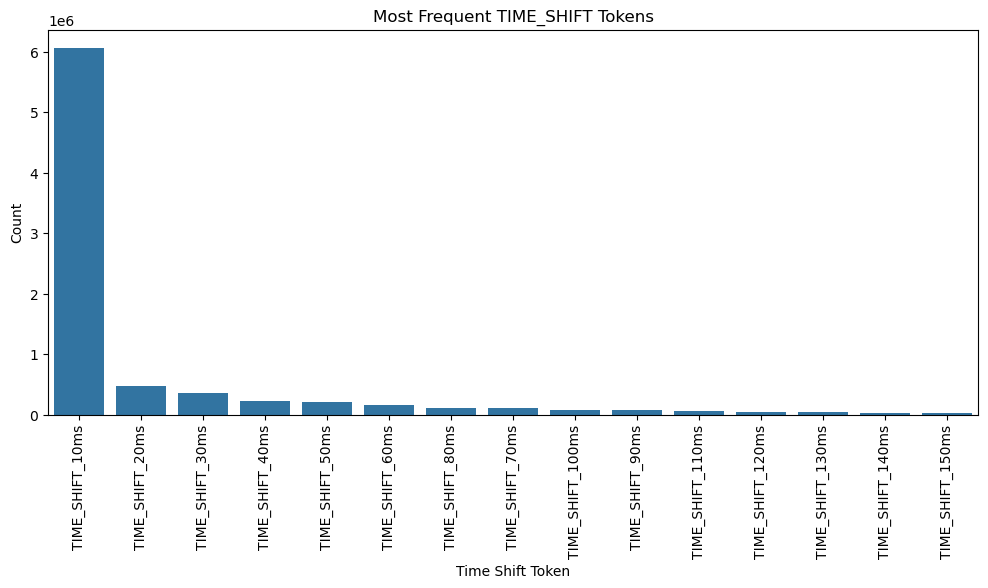

In [32]:
# Extract all TIME_SHIFT tokens
time_shift_tokens = [id_to_token[token] for token in all_tokens if "TIME_SHIFT" in id_to_token[token]]

# Count occurrences of each TIME_SHIFT value
time_shift_counts = Counter(time_shift_tokens)
sorted_shifts = sorted(time_shift_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 15 time shifts
print("Top 15 Most Frequent TIME_SHIFT Tokens:")
for shift, count in sorted_shifts[:15]:
    print(f"{shift}: {count}")

# Plot distribution of TIME_SHIFT tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_shifts[:15]], y=[t[1] for t in sorted_shifts[:15]])
plt.xticks(rotation=90)
plt.xlabel("Time Shift Token")
plt.ylabel("Count")
plt.title("Most Frequent TIME_SHIFT Tokens")
plt.show()


Top 10 Most Frequent VELOCITY Tokens:
NOTE_OFF_42: 403143
NOTE_OFF_62: 202414
NOTE_OFF_64: 196379
NOTE_OFF_54: 183217
NOTE_OFF_69: 172511
NOTE_OFF_60: 171289
NOTE_OFF_36: 164739
NOTE_OFF_67: 158225
NOTE_OFF_57: 144317
NOTE_OFF_35: 144214


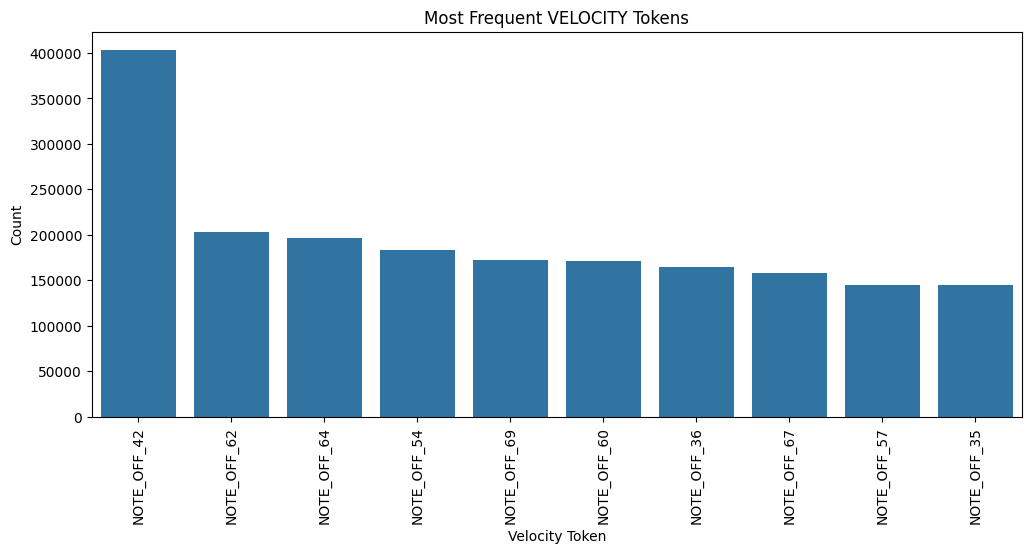

In [29]:
# Extract all VELOCITY tokens
velocity_tokens = [id_to_token[token] for token in all_tokens if "NOTE_OFF" in id_to_token[token]]

# Count occurrences
velocity_counts = Counter(velocity_tokens)
sorted_velocities = sorted(velocity_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 10 velocities
print("Top 10 Most Frequent VELOCITY Tokens:")
for vel, count in sorted_velocities[:10]:
    print(f"{vel}: {count}")

# Plot velocity distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_velocities[:10]], y=[t[1] for t in sorted_velocities[:10]])
plt.xticks(rotation=90)
plt.xlabel("Velocity Token")
plt.ylabel("Count")
plt.title("Most Frequent VELOCITY Tokens")
plt.show()
